# Two Axion System

In [1]:
import matplotlib.pyplot as plt, numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq, ifft, rfft, rfftfreq, irfft

$$
V = \sum_i \Lambda_i \left( 1 - \cos(Q_{i,j} \theta_j) \right)
$$

$$
\frac{ \partial V } { \partial \theta_k } = \sum_i \Lambda_i Q_{i,k} \sin(Q_{i,j} \theta_j)
$$

$$
\ddot{\theta}_k + 3 H \dot{\theta}_k + \frac{ \partial V } { \partial \theta_k } = 0
$$

In [2]:
def rhs(t, y, Q, Lambda):
    H = 1 / (2*t)
    N = y.size // 2
    thetas, theta_dots = y[:N], y[N:]
    force = (Lambda * np.sin(Q @ thetas)) @ Q
    theta_dotdots = - 3 * H * theta_dots - force
    return np.hstack([theta_dots, theta_dotdots])

def calc_V(thetas, Q, Lambda):
    return np.dot(Lambda, 1 - np.cos(Q @ thetas))

def calc_energy(y, Q, Lambda):
    N = len(Lambda)
    thetas, theta_dots = y[:N], y[N:]
    return 0.5 * np.sum(theta_dots**2) + calc_V(thetas, Q, Lambda)

def calc_t_interval(H0, tspan):
    start = 1 / (2*H0)
    return start, start + tspan
    
def solve(H0, tspan, thetas0, Q, Lambda):
    init = np.hstack([thetas0, np.zeros(len(Lambda))])
    sol = solve_ivp(rhs, calc_t_interval(H0, tspan), init, args=(Q, Lambda), method="LSODA", rtol=1e-10, dense_output=True)
    assert sol.success
    return sol

In [3]:
Q = np.array([[1,1], [1, 0]])
Q_inv = np.linalg.inv(Q)
eps = 1e-3
Lambda = np.array([1, 1 + eps])
H0 = 10
thetas0 = [1,1]
tspan = 100

sol = solve(H0, tspan, thetas0, Q, Lambda)
ts = np.linspace(*calc_t_interval(H0, tspan), 1000)
theta1, theta2, theta1_dot, theta2_dot = u = sol.sol(ts)
N = len(Lambda)
phi1, phi2, phi1_dot, phi2_dot = mass_states = np.vstack([Q @ u[:N, :], Q @ u[N:, :]])

In [4]:
canonical_names = [r"$\theta_1$", r"$\theta_2$", r"$\dot{\theta}_1$", r"$\dot{\theta}_2$"]
mass_states_names = [r"$\phi_1$", r"$\phi_2$", r"$\dot{\phi}_1$", r"$\dot{\phi}_2$"]
tlabel = "t H"

Text(0.5, 0, 't H')

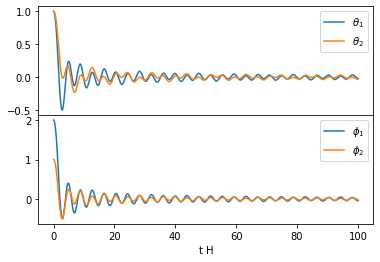

In [5]:
fig = plt.figure()
fig.subplots_adjust(hspace=0)
plt.subplot(2,1,1)
plt.plot(ts, theta1, label=canonical_names[0])
plt.plot(ts, theta2, label=canonical_names[1])
plt.legend()
plt.xlabel(tlabel)
plt.subplot(2,1,2)
plt.plot(ts, phi1, label=mass_states_names[0])
plt.plot(ts, phi2, label=mass_states_names[1])
plt.legend()
plt.xlabel(tlabel)

In [6]:
skip = tspan / 10
s = skip_steps = int(np.ceil(skip / (ts[1] - ts[0])))

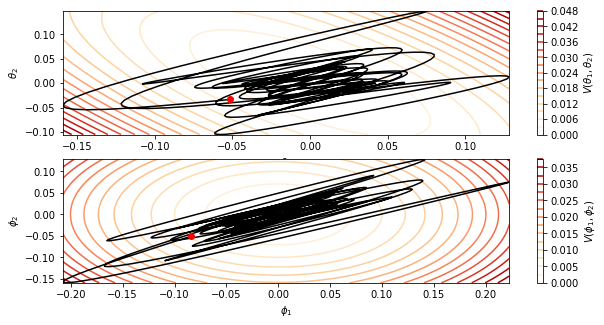

In [7]:
interval = 1e-10 #  np.pi / 4
def calc_range(x):
    return np.linspace(np.floor(np.min(x) / interval) * interval, np.ceil(np.max(x) / interval) * interval, 100)

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)

x, y = calc_range(theta1[skip_steps:]), calc_range(theta2[skip_steps:])
V = np.array([[calc_V([t1, t2], Q, Lambda) for t1 in x] for t2 in y])
plt.contour(x, y, V, levels=15, cmap="OrRd")
plt.plot(theta1[skip_steps:], theta2[skip_steps:], color="black")
plt.plot([theta1[skip_steps]], [theta2[skip_steps]], "ro")
plt.xlabel(canonical_names[0])
plt.ylabel(canonical_names[1])
plt.colorbar(label=r"$V(\theta_1, \theta_2)$")

plt.subplot(2,1,2)
x, y = calc_range(phi1[skip_steps:]), calc_range(phi2[skip_steps:])
V = np.array([[calc_V(Q_inv @ [t1, t2], Q, Lambda) for t1 in x] for t2 in y])
plt.contour(x, y, V, levels=15, cmap="OrRd")
plt.plot(phi1[skip_steps:], phi2[skip_steps:], color="black")
plt.plot([phi1[skip_steps]], [phi2[skip_steps]], "ro")
plt.xlabel(mass_states_names[0])
plt.ylabel(mass_states_names[1])
plt.colorbar(label=r"$V(\phi_1, \phi_2)$")

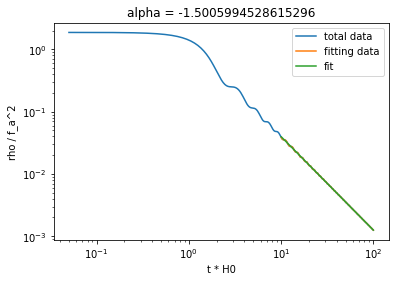

In [8]:
rho = np.array([ calc_energy(x, Q, Lambda) for x in u.T ])
plt.loglog(ts, rho, label="total data")
plt.loglog(ts[skip_steps:], rho[skip_steps:], label="fitting data")

def fit_fn(log_t, alpha, log_beta):
    return alpha * log_t + log_beta
p, cov = curve_fit(fit_fn, np.log(ts[skip_steps:]), np.log(rho[skip_steps:]), p0=(1, 1))
plt.loglog(ts[skip_steps:], np.exp(fit_fn(np.log(ts[skip_steps:]), *p)), label="fit")

plt.xlabel("t * H0")
plt.ylabel("rho / f_a^2")
plt.legend()
plt.title(f"alpha = {p[0]}")

alpha, log_beta = p

In [12]:
def analyse_power_spectrum(var):
    signal = var[s:] / ts[s:]**(alpha/2)
    dt = ts[1] - ts[0]
    freq = rfftfreq(len(signal), dt)
    ft = rfft(signal)
    pow_spec = np.abs(ft)
    is_local_max = (pow_spec[:-2] < pow_spec[1:-1]) & (pow_spec[2:] < pow_spec[1:-1])
    peaks = freq[1:-1][is_local_max]
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(ts[s:], signal)
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.subplot(1,2,2)
    plt.plot(peaks, pow_spec[1:-1][is_local_max], "or")
    plt.semilogx(freq, pow_spec)
    plt.xlabel("freq")
    plt.ylabel("power")
    return peaks

array([0.0999, 0.2553])

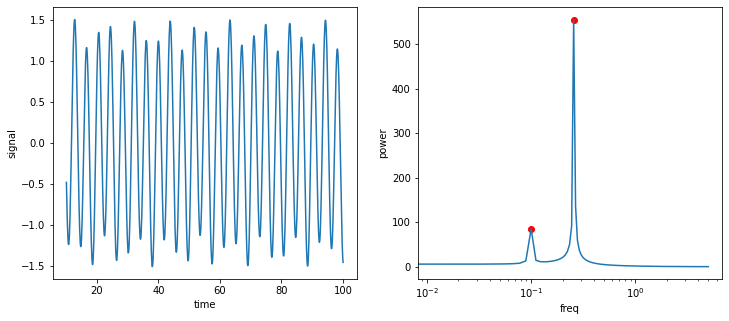

In [13]:
analyse_power_spectrum(phi1)